## 1. Imports

In [1]:
from pathlib import Path

import torch
from torch.optim import Adam

import spacy # For the tokenizer

from torchero.models.text import LinearModel, LSTMForTextClassification, TransformerForTextClassification, BinaryTextClassificationModel
from torchero.utils.text import TextClassificationDataset, transforms, vectors
from torchero.callbacks import ProgbarLogger, ModelCheckpoint, ExponentialLR
from torchero.hparams import OptimP
from torchero.utils.data import SubsetDataset

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
path = Path(r'/mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge')
label_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

We first define a basic text preprocessing pipeline

1. To lower case (default pre_process argument, can be changed)
2. Tokenization with spacy
3. Left truncation if the text exceeds 512 tokens (510 + 2 ``<bos>`` and ``<bos>`` special tokens). This is an important performance step since the training could reach and CUDA out of memory when having really long sequences with short ones padded to the longest one.
3. A vocabulary with a maximum of 10k unique tokens. Also for the tokenization begininng amd ending of sentence special tokens.
4. After the vocabulary has converted each token to an id we create a LongTensor

In [3]:
transform = transforms.basic_text_transform(tokenizer='spacy',
                                            vocab_max_size=10000,
                                            bos='<bos>',
                                            eos='<eos>',
                                            max_len=510,
                                            truncate_mode='left')

## Load the dataset

We will load the dataset from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). The original train.csv file has been splitted into train and test in a stratified fashion. The csv consists of an input text (```comment_text```column) and a set of labels (multilabel) to predict:

* toxic
* severe_toxic
* obscene
* threat
* insult 
* identity_hate

In [4]:
!head -n 1 /mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train_tiny.csv

id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [5]:
train_ds = TextClassificationDataset.from_csv(path/'train_subset.csv',
                                              columns='comment_text',
                                              target_columns=label_cols,
                                              transform=transform)
test_ds = TextClassificationDataset.from_csv(path/'test_subset.csv',
                                             columns='comment_text',
                                             target_columns=label_cols,
                                             transform=transform)

The challenge with this dataset is that although it has a lot of samples where to learn from is highly unbalanced. Only 10% percent has a positive label (which we can calculate inspecting at target_data dataset's property)

In [6]:
print("Train size: {}. Test size: {}".format(len(train_ds), len(test_ds)))
train_ds.target_data.any(axis=1).value_counts(normalize=True)

Train size: 119678. Test size: 39893


False    0.898319
True     0.101681
dtype: float64

To create the vocabulary before training we need to call first to ``transform.fit`` property on the train dataset texts.

In [7]:
transform.fit(train_ds.texts())

To boost up the training we can use a set of pretrained GloVe word embeddings for twitter comments and replace each model's embedding to use this vectors.

In [8]:
twitter_vectors = vectors.GLoVeVectors.from_url('twitter', dim=200)

glove.twitter.27B.zip: 1.52GB [05:30, 4.60MB/s]                               


We will start by training two models for this task.

## Linear Model

The lienar model consists simply of an EmbeddingBag layer followed by a Classification Head. The only parameters needed are:

1. **vocab_size**=len(transform.vocab): the size of the vocabulary which we can get from the transform.vocab component.
2. **embedding_dim**=200: Since we are using pretrained word vectors we need to match the size of them with the size of the vectors of embedding layer
3. **output_size**=len(label_cols): Number of outputs in the classification layer.

In [9]:
len(transform.vocab)

10000

In [10]:
linear_model = BinaryTextClassificationModel(LinearModel(vocab_size=len(transform.vocab),
                                                         embedding_dim=200,
                                                         output_size=len(label_cols)),
                                             transform=transform,
                                             labels=label_cols)

In [11]:
linear_model.model

LinearModel(
  (embeddings): EmbeddingBag(10000, 200, mode=mean)
  (linear): Linear(in_features=200, out_features=6, bias=True)
)

The Linear model will be compiled with

* **Optimizer**: Adam as our optimizer with a learning rate 0.01 (higher than usual because we have to train the classification layer becuase the embedding is frozen)
* **HyperParameters**: Lr as our hyperparameter to track during the training
* **Metrics**: Default metrics for binary multilabel classification tasks (recall, precision, f1, loss and accuracy) 
* **Callbacks**:
    * ProgbarLogger to display a progress bar
    * ModelCheckpoint to checkpoint the model if there is an improvement in the val_f1 metric
    * ExponentialLR to decay the learning rate by 80% after each epoch

In [12]:
linear_model.compile(optimizer=Adam(linear_model.model.parameters(), lr=0.01),
                     hparams={'lr': OptimP('lr')},
                     callbacks=[ProgbarLogger(notebook=True),
                                ModelCheckpoint('/tmp/linear_checkpoint', monitor='val_f1'),
                                ExponentialLR(gamma=0.8, start=1)])
if torch.cuda.is_available():
    linear_model.to('cuda')

  0%|          | 0/15 [00:00<?, ?epoch/s]

  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint'


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.560 to 0.639


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.639 to 0.657


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.657 to 0.670


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.670 to 0.674


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.674 to 0.678


  0%|          | 0/117 [00:00<?, ? batchs/s]

  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.678 to 0.683


  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.683 to 0.686


  0%|          | 0/117 [00:00<?, ? batchs/s]

  0%|          | 0/117 [00:00<?, ? batchs/s]

  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.686 to 0.686


  0%|          | 0/117 [00:00<?, ? batchs/s]

  0%|          | 0/117 [00:00<?, ? batchs/s]

Model saved to '/tmp/linear_checkpoint': val_f1 improved from 0.686 to 0.687


  0%|          | 0/117 [00:00<?, ? batchs/s]

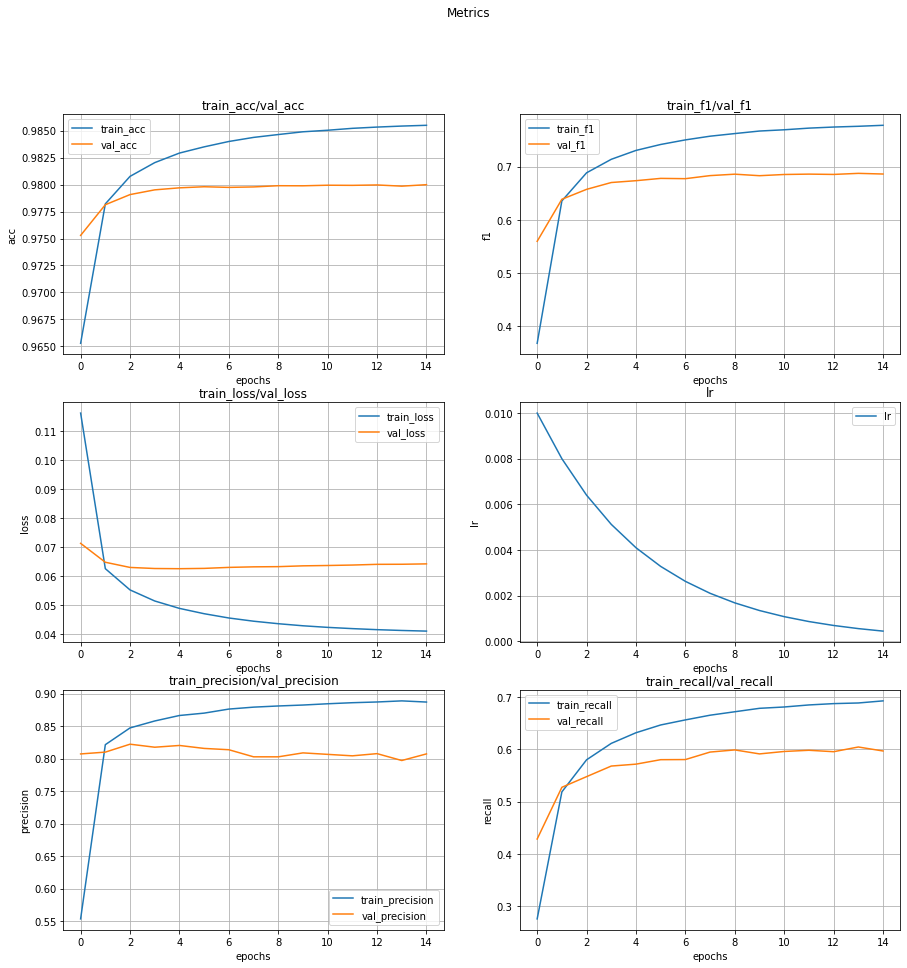

In [13]:
history_linear = linear_model.fit(train_ds, test_ds, epochs=15, batch_size=1024)
history_linear.plot()
plt.show()

Then we free the GPU memory used by the Linear model to allocate it for the LSTM model

In [14]:
linear_model.load_checkpoint()
linear_clf_report = linear_model.classification_report(test_ds)
linear_model.to('cpu')
torch.cuda.empty_cache()

/home/chino/Proyectos/Machine Learning/torchero/examples/notebooks/torchero/callbacks/checkpoint.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


## LSTM

LSTMForTextClassification is an Embedding layer followed by a LSTM and then by a Linear Classification layer. The arguments variation for the LSTMForTextClassification module are:

* **vocab_size**: Number of embeddings of the embedding layer
* **output_size**=6: Number of outputs of the classification labels (number of labels to predict)
* **hidden_size**=300. LSTM hidden and context layer size.
* **embedding_dim**=200. Same as in LinearModel needs to match the pretrained vectors size.
* **num_layers**=2. Number of LSTM layers to stack.
* **mode**='max'. Pooling method. 'max' uses a global max pooling over the whole sequence last layer activations. 'last' pools the last unit of the last layer.

The compilation will be similar as for the Linear model with the only difference of the learning rate that is initially lower.

In [15]:
lstm_model = BinaryTextClassificationModel(LSTMForTextClassification(vocab_size=len(transform.vocab),
                                                                     output_size=len(label_cols),
                                                                     hidden_size=300,
                                                                     embedding_dim=200,
                                                                     num_layers=2,
                                                                     bidirectional=True,
                                                                     mode='max'),
                                           transform=transform,
                                           labels=label_cols)
twitter_vectors.replace_embeddings(transform.vocab, lstm_model.model.embeddings, freeze=True)
lstm_model.compile(optimizer=Adam(lstm_model.model.parameters(), lr=0.005),
                   hparams={'lr': OptimP('lr')},
                   callbacks=[ProgbarLogger(notebook=True),
                              ModelCheckpoint('/tmp/lstm_checkpoint', monitor='val_f1'),
                              ExponentialLR(gamma=0.8, start=1)])
if torch.cuda.is_available():
    lstm_model.to('cuda')

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint'


Model saved to '/tmp/lstm_checkpoint'
Model saved to '/tmp/lstm_checkpoint'
Model saved to '/tmp/lstm_checkpoint'
Model saved to '/tmp/lstm_checkpoint'
Model saved to '/tmp/lstm_checkpoint'
Model saved to '/tmp/lstm_checkpoint'


  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717


Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.672 to 0.717


  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718


Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.717 to 0.718


  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719


Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.718 to 0.719


  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728


Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.719 to 0.728


  0%|          | 0/599 [00:00<?, ? batchs/s]

INFO:Trainer:Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734


Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734
Model saved to '/tmp/lstm_checkpoint': val_f1 improved from 0.728 to 0.734


  0%|          | 0/599 [00:00<?, ? batchs/s]

  0%|          | 0/599 [00:00<?, ? batchs/s]

  0%|          | 0/599 [00:00<?, ? batchs/s]

  0%|          | 0/599 [00:00<?, ? batchs/s]

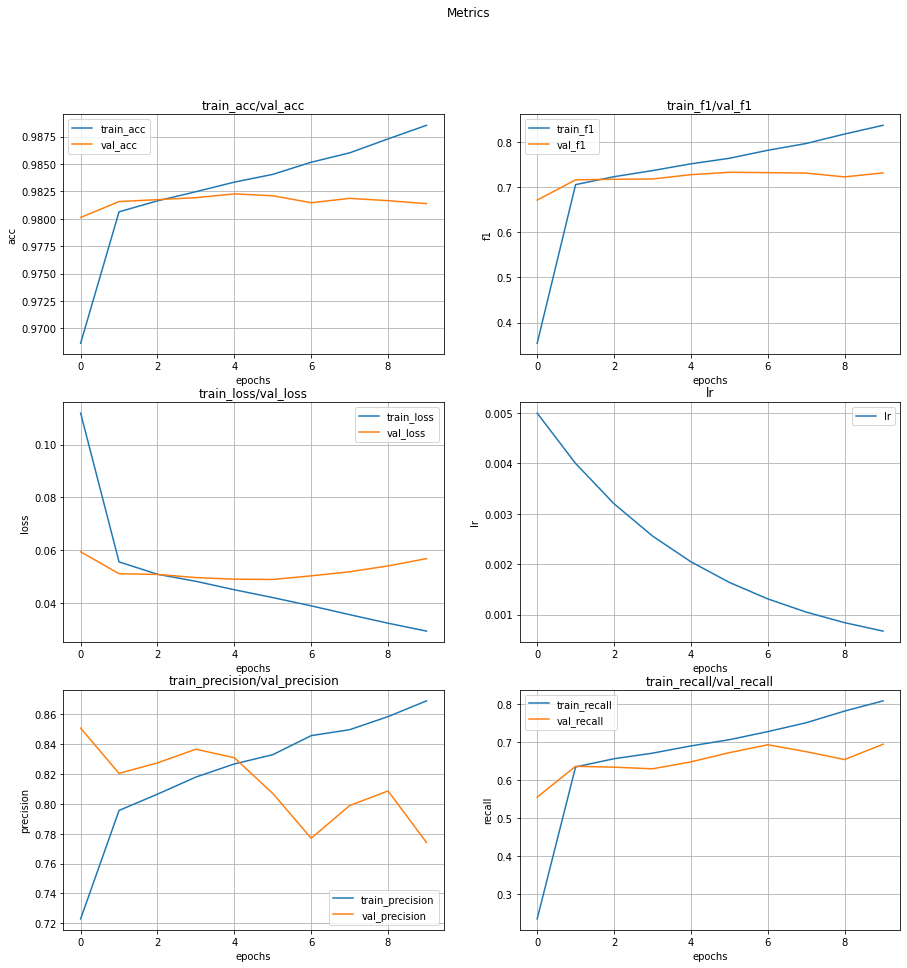

In [16]:
history_lstm = lstm_model.fit(train_ds, test_ds, epochs=10, batch_size=200)
history_lstm.plot()
plt.show()

In [17]:
lstm_model.load_checkpoint()
lstm_clf_report = lstm_model.classification_report(test_ds)
lstm_model.to('cpu')
torch.cuda.empty_cache()

/home/chino/Proyectos/Machine Learning/torchero/examples/notebooks/torchero/callbacks/checkpoint.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f)


## Results

In [18]:
import pandas  as pd

In [19]:
pd.concat([
    pd.DataFrame.from_dict(clf_report, orient='index').assign(name=name)
    for name, clf_report in {'linear': linear_clf_report,
                             'lstm': lstm_clf_report}.items()
], axis=0).set_index('name', append=True).unstack(level=1)

precision              recall            f1-score            \
name             linear      lstm    linear      lstm    linear      lstm   
identity_hate  0.460432  0.000000  0.190476  0.000000  0.269474  0.000000   
insult         0.766736  0.720102  0.564820  0.719370  0.650468  0.719736   
macro          0.659633  0.538528  0.433990  0.379968  0.513890  0.400481   
micro          0.796964  0.808787  0.604399  0.673467  0.687451  0.734950   
obscene        0.849102  0.846033  0.672676  0.763757  0.750662  0.802792   
severe_toxic   0.548781  0.826087  0.331695  0.046683  0.413476  0.088372   
threat         0.510638  0.000000  0.176471  0.000000  0.262295  0.000000   
toxic          0.822108  0.838946  0.667801  0.750000  0.736964  0.791983   
weighted       0.784822  0.768277  0.604399  0.673467  0.680598  0.703140   

              support        
name           linear  lstm  
identity_hate     336   336  
insult           1967  1967  
macro            8774  8774  
micro            8774  8774  
obscene          2108  2108  
severe_toxic      407   407  
threat            136   136  
toxic            3820  3820  
weighted         8774  8774

## Prediction with best model

In [20]:
lstm_model.predict('You can go to hell')

{'toxic': 0.9332311749458313, 'severe_toxic': 0.05339151993393898, 'obscene': 0.38970574736595154, 'threat': 0.015076501294970512, 'insult': 0.29866260290145874, 'identity_hate': 0.03540885075926781}